# House Price Prediction

```Data/house_price.csv```には、住宅の価格(```SalePrice```)と住宅の関連情報が格納されています。

- このデータを用いて、住宅の価格(```SalePrice```)を予測するモデルを構築、評価しなさい。
- データ中身を確認しながら、適切な特徴量エンジニアリングやモデル選定ための考えもまとめてください。

変数に関する詳細や分析の進め方についての理解が不足していたため、次のウェブサイトを大いに参考にした。  
https://note.com/ewkyd04r/n/nd9f15c0c6085  
https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook  
参考にはしたものの、あまり参考にならないコードや考え方もあったため、その都度自分で考えた。

## データセットの確認、変数の選定、探索的なデータ分析  
- 始めに、上記で示したウェブサイトを参考に各変数を確認し、直感的に住宅価格と変数の関連を考えた  
- 次に、探索的なデータ分析の結果と直感的な考察のそれぞれをふまえて、最終的に回帰モデルに投入する変数を決定した

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

house_price = pd.read_csv("Data/house_price.csv")

In [108]:
##変数の確認
house_price.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [109]:
##まずSalePrice(予測する変数)の統計量を確認
house_price["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

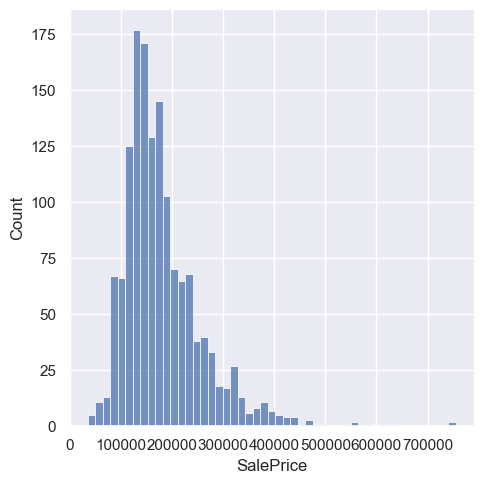

In [113]:
##住宅価格の分布
sns.displot(house_price["SalePrice"]);

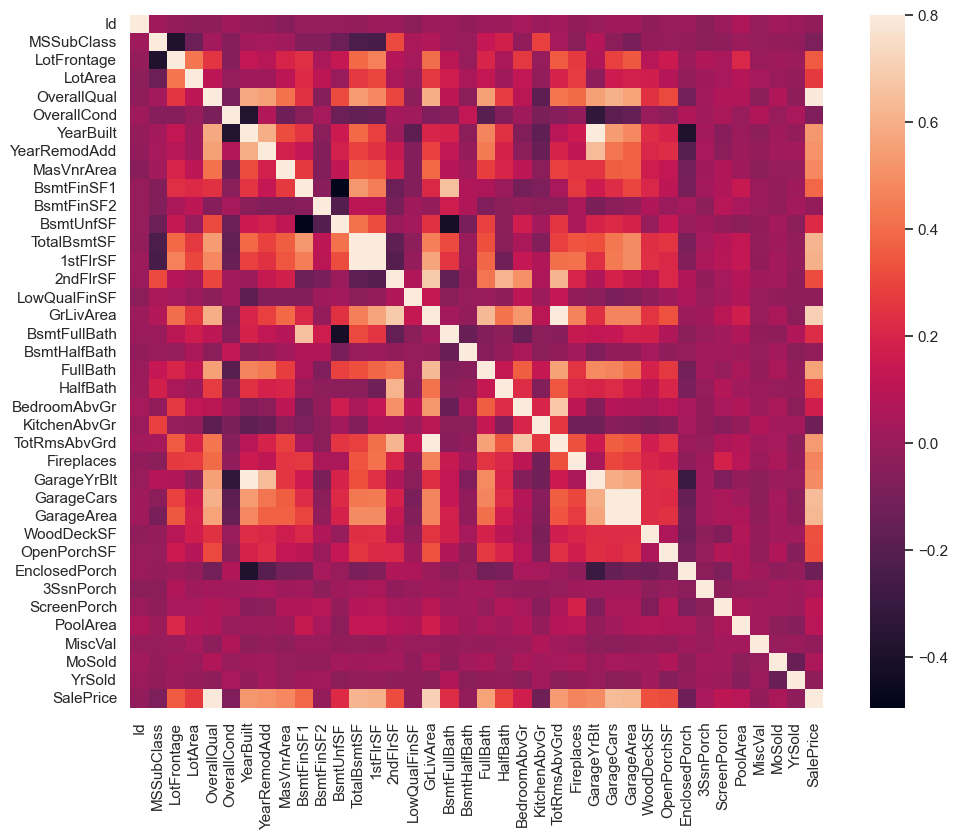

In [118]:
##相関行列　numeric_only
corrmat = house_price.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

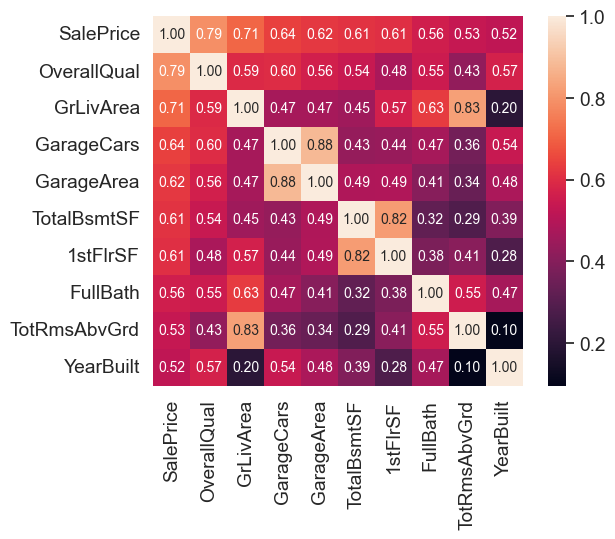

In [119]:
##Salepriceに注目した相関行列
##GarageAreaとGarageCarsのように関連性が強いと考えられる変数については以下ではどちらか一方の変数のみを扱うことにした（多重共線性を避けるため）
k = 10 #変数の数
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house_price[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

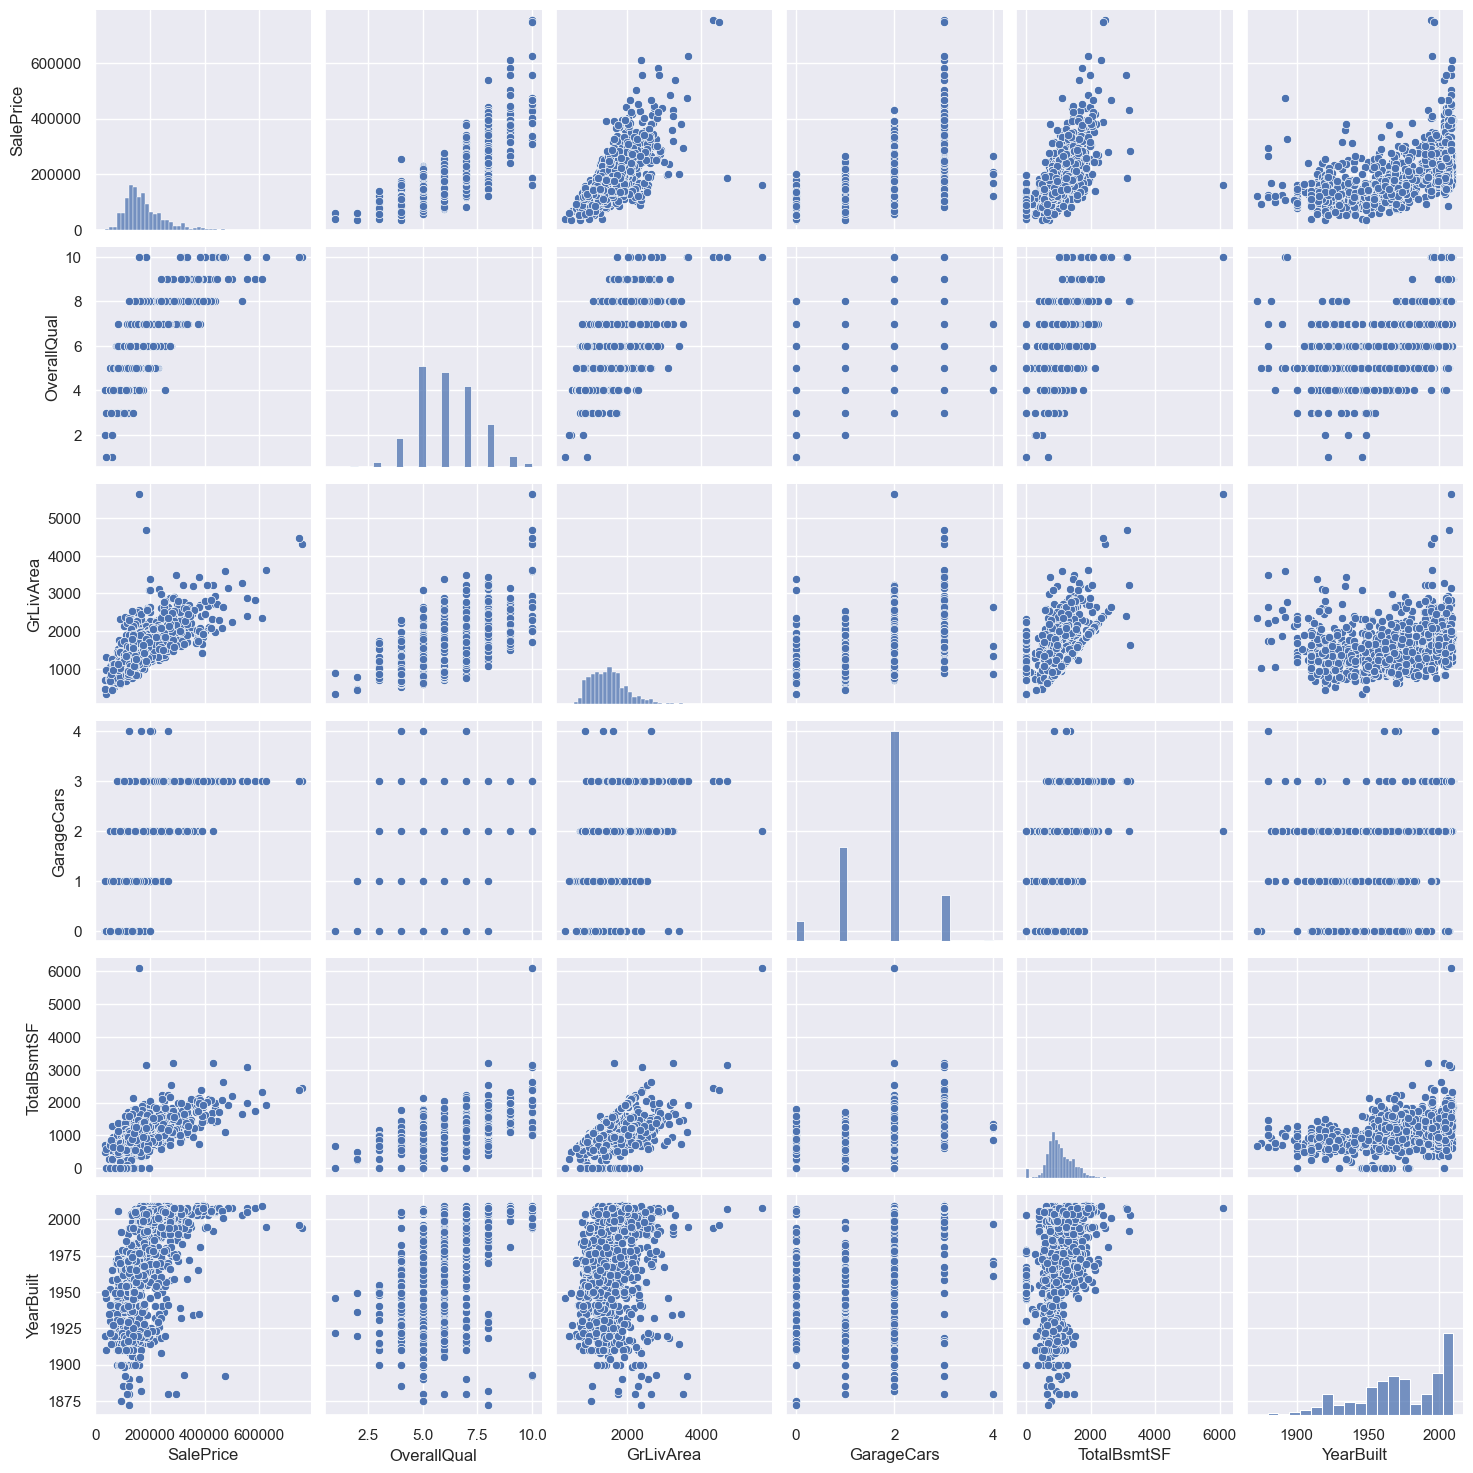

In [120]:
##散布図
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
sns.pairplot(house_price[cols], size = 2.5)
plt.show();

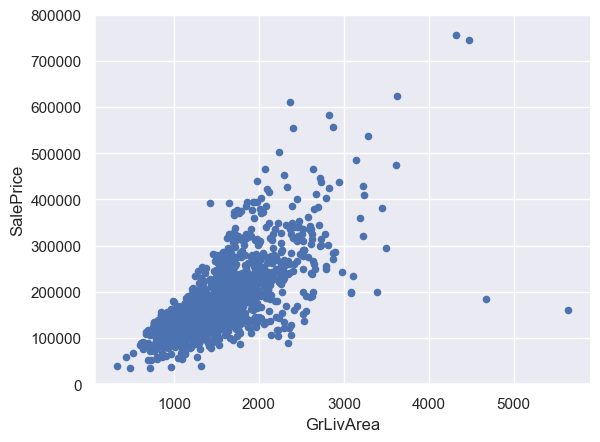

In [112]:
##GrLivArea: Above grade (ground) living area square feet, 地上の床面積と住宅価格の関連
var = 'GrLivArea'
data = pd.concat([house_price['SalePrice'], house_price[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

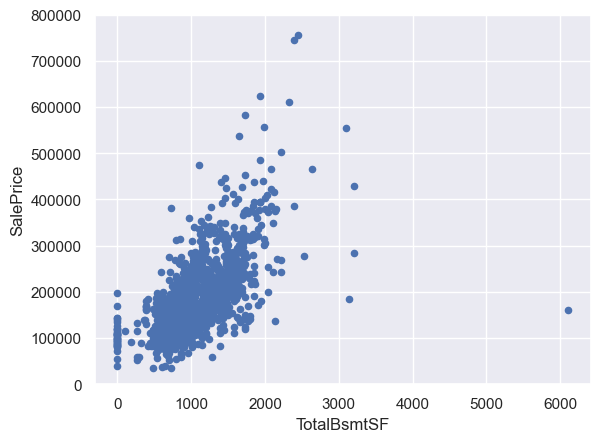

In [115]:
##TotalBsmtSF: Total square feet of basement area, 地下室の延べ床面積と住宅価格の関連
var = 'TotalBsmtSF'
data = pd.concat([house_price['SalePrice'], house_price[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

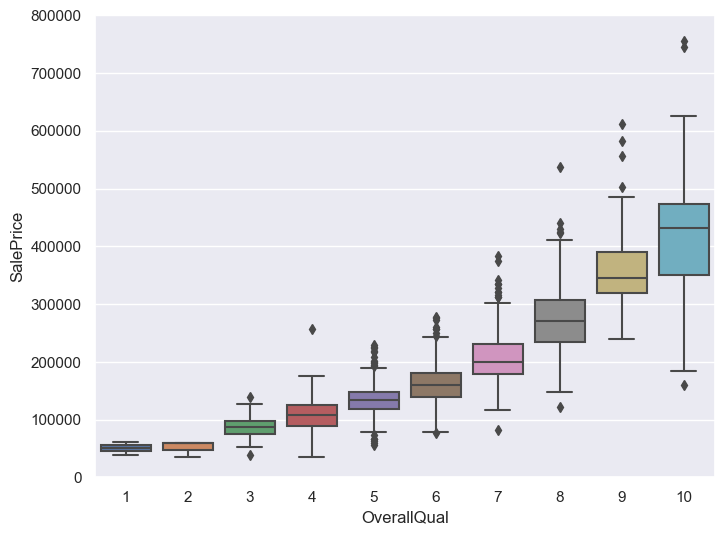

In [116]:
##OverallQual: Rates the overall material and finish of the house（材質や家の完成度についての評価、離散変数　1から10）
##住宅の評価と住宅価格の関連
var = 'OverallQual'
data = pd.concat([house_price['SalePrice'], house_price[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

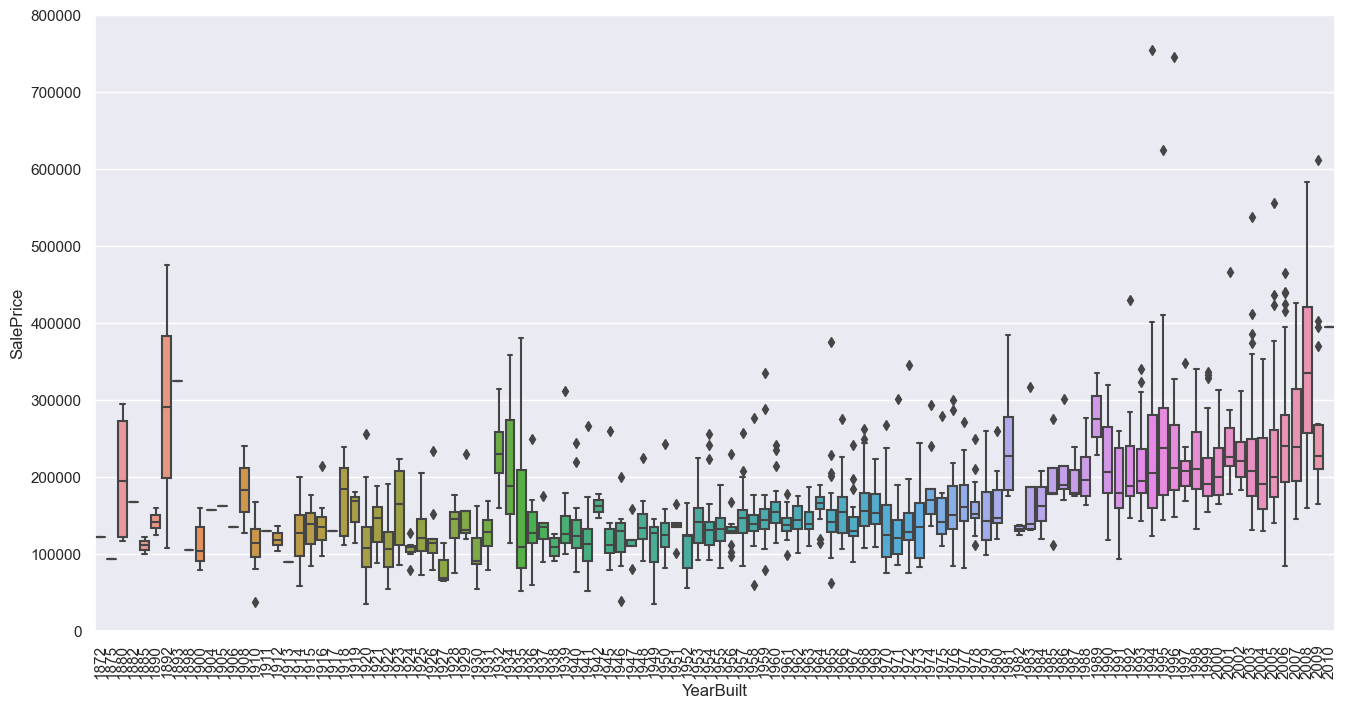

In [117]:
##YearBuilt: Original construction date（建築年）　建築年と住宅価格の関連
var = 'YearBuilt'
data = pd.concat([house_price['SalePrice'], house_price[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

## 回帰モデルの構築と当てはめ、予測、評価  
- 最終的に採用した5つの変数を独立変数として回帰モデルを構築し、住宅価格を予測した  
- 誤差が大きいという結果をふまえて、住宅価格を対数変換して再度回帰モデルを構築した

In [126]:
##データ分割、回帰モデル、予測、予測の評価
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = house_price[["YearBuilt", "TotalBsmtSF", "GrLivArea", "OverallQual", "GarageCars"]]
Y = house_price[["SalePrice"]] 

# 訓練データとテストデータに分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

model=LinearRegression() # 線形回帰モデル
model_fit = model.fit(X_train,Y_train) # モデルを訓練データに適合
y_predicted=model.predict(X_test) # テストデータで予測
MSE = mean_squared_error(Y_test,y_predicted) # 予測精度（平均二乗誤差）の評価
print("LinearRegression MSE: ", MSE)


LinearRegression MSE:  1298494603.2625277


In [154]:
##係数
coef = model_fit.coef_.flatten()
pd.DataFrame({"Name": X.columns, "Coeffcients": coef})

,Name,Coeffcients
0,YearBuilt,280.587799
1,TotalBsmtSF,25.793026
2,GrLivArea,45.292383
3,OverallQual,20300.140045
4,GarageCars,17613.070702


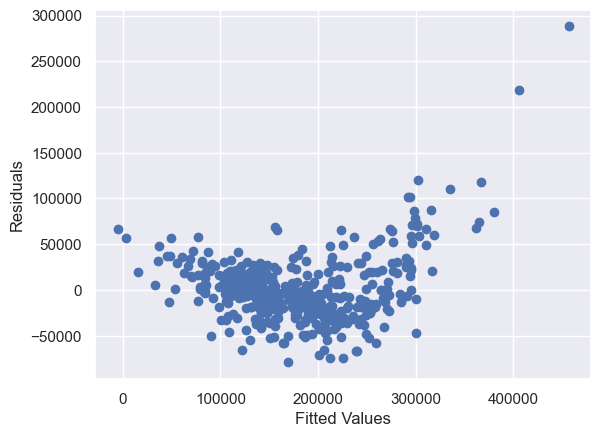

In [140]:
##残差プロット
##誤差があまりにも大きいため、回帰分析の前提を確認してみる
##住宅価格が高い方で残差が大きくなっており、残差の分散が均一ではない。うまく推定が行われていない可能性がある
predictions = y_predicted.reshape(438, 1)
residual = Y_test - predictions
plt.scatter(y_predicted, residual)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

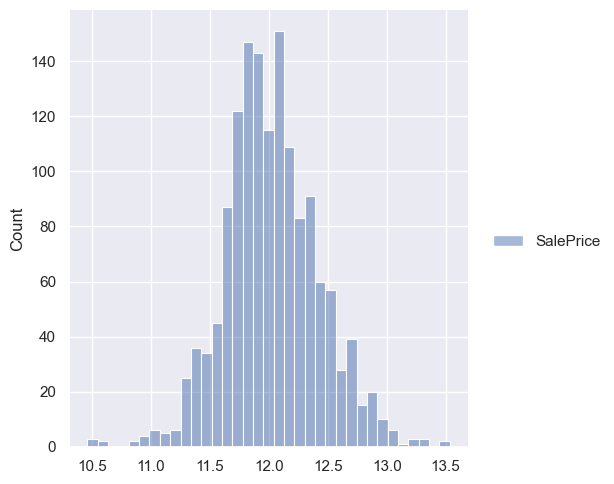

In [145]:
##もともとの住宅価格の分布の歪みをなくすため、住宅価格を対数変換する
Y2 = np.log(house_price[['SalePrice']])
sns.displot(Y2);

In [146]:
##model2
##住宅価格を対数変換したバージョン

# 訓練データとテストデータに分割
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.3, random_state=1)

model2=LinearRegression() # 線形回帰モデル
model2_fit = model2.fit(X2_train,Y2_train) # モデルを訓練データに適合
y_predicted2=model2.predict(X2_test) # テストデータで予測
MSE2 = mean_squared_error(Y2_test,y_predicted2) # 予測精度（平均二乗誤差）の評価
print("LinearRegression MSE: ", MSE2)


LinearRegression MSE:  0.030749655153438277


In [155]:
##model2 係数
coef = model2_fit.coef_.flatten()
pd.DataFrame({"Name": X.columns, "Coeffcients": coef})

,Name,Coeffcients
0,YearBuilt,0.002139
1,TotalBsmtSF,0.000107
2,GrLivArea,0.000222
3,OverallQual,0.100317
4,GarageCars,0.099825


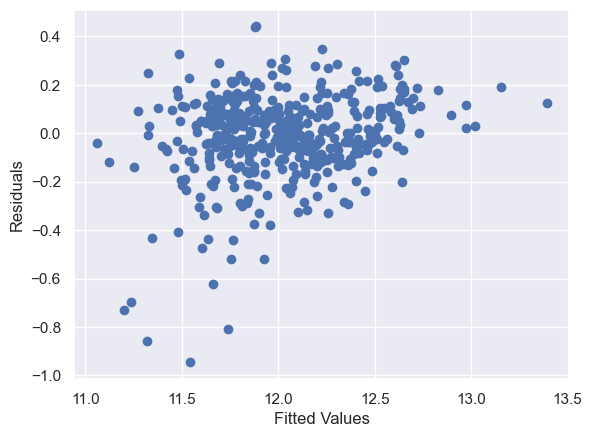

In [147]:
##残差プロット
##対数変換前と比べて残差はゼロを中心に散らばっていると言える
predictions2 = y_predicted2.reshape(438, 1)
residual2 = Y2_test - predictions2
plt.scatter(y_predicted2, residual2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


## 結論  
- 最終的に採用したモデルをふまえると、住宅への評価やガレージの大きさが住宅価格に大きな影響を与えることがわかった  
- 誤差をより小さくするためには、最小二乗法による回帰分析以外の手法や重要な変数の見落としの有無を検討する必要がある